In [2]:
import pandas as pd
import numpy as np
from geopy import distance
from matplotlib import pyplot as plt 

pd.options.mode.chained_assignment = None

In [3]:
# Read in CSV and do some preprocessing
df = pd.read_csv("penguin.csv")
df.dropna(inplace=True)
df.drop(columns=[
    "event-id", 
    "visible", # boolean indicating visibility, ignore False
    "migration-stage", 
    "tag-tech-spec", 
    "sensor-type",
    "individual-local-identifier", # individual id 
    "study-name",
    "individual-taxon-canonical-name" # species name 
    ], inplace=True)

df["timestamp"] = pd.to_datetime(df["timestamp"]) 
# used to simulate arrival times of penguins

# Seperate data by season
seasons = df["comments"].unique().tolist()

# Define nest location and boundary
nest_location = (-66.663596, 140.004067) 
radius = 1.0 # 1km away from nest 

In [36]:
""" Collect departure time for each season
    Use it as real-world event timestamps to:
    1. Derive empirical arrival rate funtion λ(t) for NSPP
    2. Ensure varied time rate model, realistic simulation 
"""
departures = {} # Departure timestamps per 
departures_by_day = {}
departure_no_year = []
for season in seasons:
    season_df = df[df["comments"] == season] # list of all individuals in a particular season
    penguin_ids = season_df["tag-local-identifier"].unique().tolist() # extract unique ids of individuals from season_df list

    years = season.split("-")
    #season_departures = []

    # Look through all penguins 
    for id in penguin_ids:
        penguin_df = season_df[season_df["tag-local-identifier"] == id] # extract all rows of a particular individual id
        penguin_df.sort_values(by="timestamp", inplace=True)

        # coordinate tuple: current penguin first recorded location
        coord = (penguin_df["location-lat"].iloc[0], penguin_df["location-long"].iloc[0])
        # get distance between nest and penguin
        prev_dist = distance.distance(nest_location, coord).km

        # Look through all movement lines of an individual
        for i in range(1, penguin_df.shape[0]):
            # iterate over all rows of the current penguin for location
            coord = (penguin_df["location-lat"].iloc[i], penguin_df["location-long"].iloc[i])
            cur_dist = distance.distance(nest_location, coord).km

            # If moved out of radius, add timestamp
            if prev_dist < radius and cur_dist >= radius:
                # capture time of the departure at current row i
                time = penguin_df["timestamp"].iloc[i]
                # parse year1 - year2
                # set all year1 to 2000 and year2 to 2001
                # combine into a big list of only season 2000-2001
                if time.year == years[0]:
                    time.replace(year=2000)
                else:
                    time.replace(year=2001)
                departure_no_year.append(time)
                # sort departure_no_year 
                # then calculate interarrival time (between every timestamp)
                # determine the number of bins and size of bin [)
                # then make histogram with y-axis is the number of interarrivals in one bin 

                
                #season_departures.append(time)
                
                # group (departure) time by day of the year
                # the day th in the year
                key = time.dayofyear
                # If the departure occurs in the afternoon (after 12:00 PM)
                # add 0.5 to key to distinguish between morning and afternoon departures.
                # if key = Jan
                if time.hour >= 12: key += 0.5 

                if key not in departures_by_day:
                    departures_by_day[key] = []

                departures_by_day[key].append(time)

            prev_dist = cur_dist
        
    season_departures = np.array(season_departures)
    season_departures = np.sort(season_departures)

    departures[season] = season_departures


# Penguin Behaviour Model: penguin movement patterns and interactions
# TODO: compute global arrival rate λ(t) from departures[season]
    # penguin behaviours may change for different season => different rate λ(t)
# TODO: arrival rate function for intervals 
# (eg. 12 hours intervals (0-12, 12-24))
    # TODO: calculate average arrival rate for each interval
# simulate penguin arrivals using the function

# Environment Model: resource points and properties (richness and location 
# and desirability score based on distanc from penguin and richness)
# 


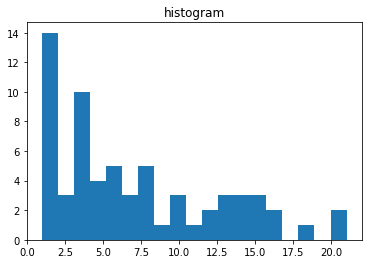

In [51]:
# Histogram of departures per day 
# Frequency: the number of penguins departing in a day
days = list(departures_by_day.keys())
counts = [0] * len(days)
for i in range(len(days)):
    counts[i] = len(departures_by_day[days[i]])

plt.hist(counts, bins=len(set(counts))//1) 
plt.title("histogram") 
plt.show()